In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from radar_simulation import ChirpConfiguration
from radar_simulation import MIMOConfiguration
from radar_simulation import FMCWMIMORadar
from radar_simulation import TargetObject
from signal_processing import RangeDopplerFFT
from signal_processing import BeamFormingDOA
from signal_processing import MUSIC
from sensor import ULA

In [ ]:
# (0) setup
# (0.1) 8-ULA
num_tx = 1
num_rx = 8
txl = np.zeros((num_tx, 3))
txl[0, 0] = 0
rxl = np.zeros((num_rx, 3))
rxl[:,0] = np.arange(num_rx)
# (0.1) configuration
cc = ChirpConfiguration()
mc = MIMOConfiguration(txl, rxl, cc.start_lambda, 0.5)
radar = FMCWMIMORadar(cc, mc)
# (0.2) object
objs = list()
objs.append(TargetObject(7, 1, -10))
objs.append(TargetObject(17, -2, 10))

In [ ]:
# (1) do simulation
num_frames = 10
dc = radar.get_data_cube(num_frames, objs)

Text(0.5, 0, 'Range [m]')

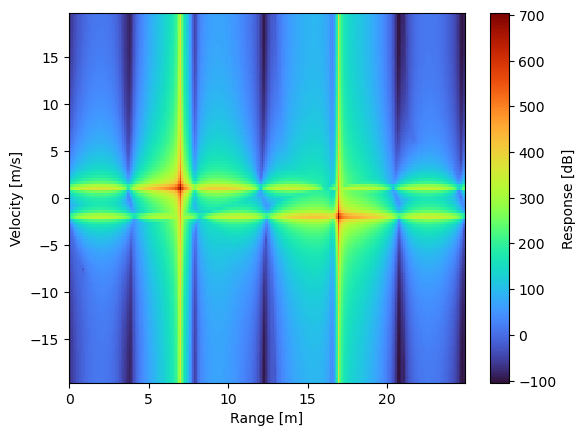

In [ ]:
postproc = RangeDopplerFFT()
rdm = postproc.get_2d_fft(dc)

target_frame = 0
rdm0_dB = np.sum(20 * np.log10((np.abs(rdm[target_frame,:,:,:,:]))), (1, 0))

range_bin = postproc.get_range_bins(cc)
velocity_bin = postproc.get_velocity_bins(cc)

fig, ax = plt.subplots()
cm = ax.pcolor(range_bin, velocity_bin, rdm0_dB, cmap='turbo')
fig.colorbar(cm, ax=ax, label='Response [dB]')
ax.set_ylabel('Velocity [m/s]')
ax.set_xlabel('Range [m]')

In [ ]:
# in realistic case use somewhat detection method like the CFAR
d_range, d_doppler = (72, 174), (67, 57)

bf = BeamFormingDOA(mc)
angle_bins = bf.get_angle_bins(d=mc.d)
angle_bins_degrees = np.rad2deg(angle_bins)

angle_spectrum = list()
for k, l in zip(d_range, d_doppler):
    signal = mva.get_signal(rdm[target_frame,:,:,l,k])
    s = bf.get_angle_fft(signal)
    angle_spectrum.append(s)

rm = postproc.get_1d_fft(dc)
ram = np.empty((rm.shape[4], bf.angle_fft_size), dtype=rm.dtype)
for k in range(ram.shape[0]):
    signal = mva.get_signal(rm[target_frame,:,:,:,k])
    signal = np.mean(signal, axis=1)
    s = bf.get_angle_fft(signal)
    ram[k,:] = s

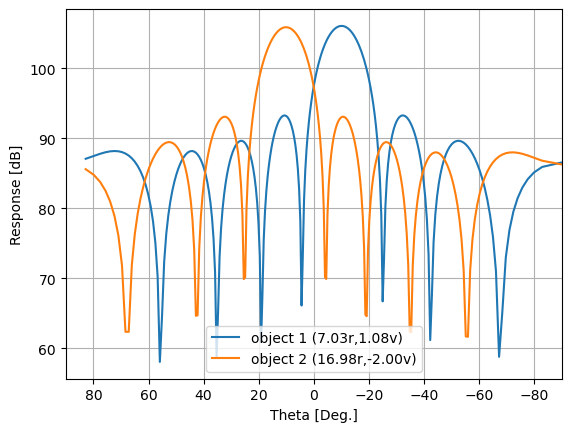

In [ ]:
angle_spectrum_power_dB = list()
for s in angle_spectrum:
    p = 20 * np.log10(np.abs(s))
    angle_spectrum_power_dB.append(p)

fig, ax = plt.subplots()
ax.set_ylabel('Response [dB]')
ax.set_xlabel('Theta [Deg.]')
ax.set_xlim([-90, 90])
ax.invert_xaxis()
for k in range(len(angle_spectrum_power_dB)):
    l = 'object {} ({:.2f}r,{:.2f}v)'.format(k + 1, range_bin[d_range[k]], velocity_bin[d_doppler[k]])
    ax.plot(angle_bins_degrees, angle_spectrum_power_dB[k], label=l)
ax.grid()
ax.legend()

Text(0, 0.5, 'Range [m]')

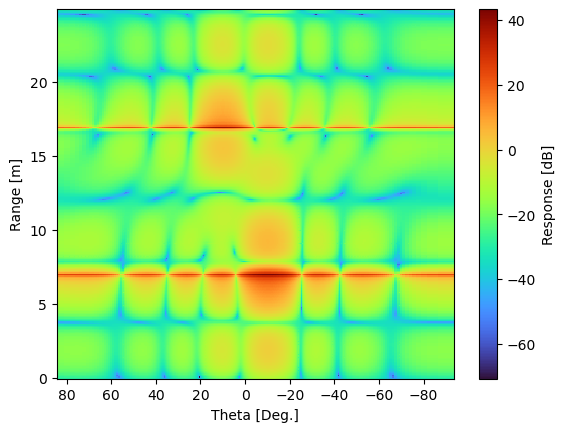

In [ ]:
ram_dB = 20 * np.log10(np.abs(ram))

fig, ax = plt.subplots()
cm = ax.pcolor(angle_bins_degrees, range_bin, ram_dB, cmap='turbo')
fig.colorbar(cm, ax=ax, label='Response [dB]')
ax.invert_xaxis()
ax.set_xlabel('Theta [Deg.]')
ax.set_ylabel('Range [m]')

Text(0, 0.5, 'Range [m]')

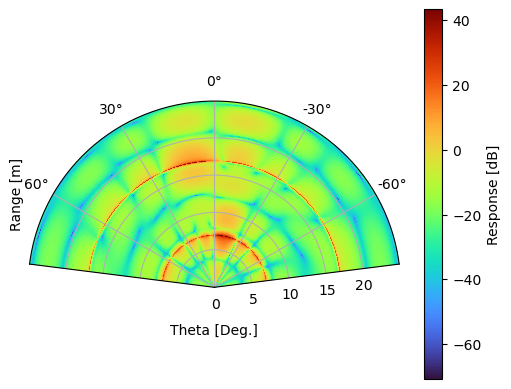

In [ ]:
lim_angle = np.max(angle_bins)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
cm = ax.pcolor(angle_bins, range_bin, ram_dB, cmap='turbo')
fig.colorbar(cm, ax=ax, label='Response [dB]')
ax.set_theta_zero_location('N')
ax.set_thetalim([-lim_angle, lim_angle])
ax.set_xlabel('Theta [Deg.]', labelpad=-40)
ax.set_ylabel('Range [m]')

In [ ]:
ula = ULA(nr = rm.shape[2], d = mc.d) # 8-ULA
rank_est_1 = lambda x:  1 # dummy functor
rank_est_0 = lambda x:  0 # dummy functor
mu1 = MUSIC(rank_est_1)
mu0 = MUSIC(rank_est_0)

rmm = np.empty((rm.shape[4], bf.angle_fft_size), dtype=rm.dtype) # range-music-map
steering = ula.get_steering_vector_matrix(angle_bins)

for k in range(rmm.shape[0]):
    signal = mva.get_signal(rm[target_frame,:,:,:,k])
    Rxx = np.dot(signal, signal.conj().T) / signal.shape[1]
    if k in d_range:
        rmm[k,:] = mu1.get_music_spetrum(Rxx, steering) # object is detected
    else:
        rmm[k,:] = mu0.get_music_spetrum(Rxx, steering) # object is not detected

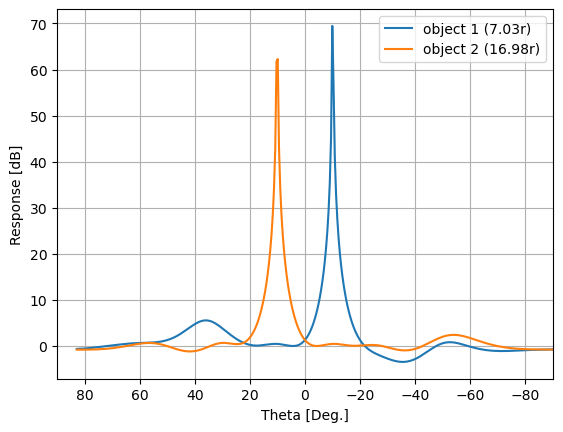

In [ ]:
# music-spectrum for detected object
music_spec = np.empty((len(d_range), angle_bins.shape[0]), dtype=signal.dtype)
for k, kk in zip(d_range, range(len(d_range))):
    music_spec[kk, :] = rmm[k, :]

music_spectrum_power_dB = list()
for s in music_spec:
    p = 20 * np.log10(np.abs(s))
    music_spectrum_power_dB.append(p)

fig, ax = plt.subplots()
ax.set_ylabel('Response [dB]')
ax.set_xlabel('Theta [Deg.]')
ax.set_xlim([-90, 90])
ax.invert_xaxis()
for k in range(len(music_spectrum_power_dB)):
    l = 'object {} ({:.2f}r)'.format(k + 1, range_bin[d_range[k]])
    ax.plot(angle_bins_degrees, music_spectrum_power_dB[k], label=l)
ax.grid()
ax.legend()

Text(0, 0.5, 'Range [m]')

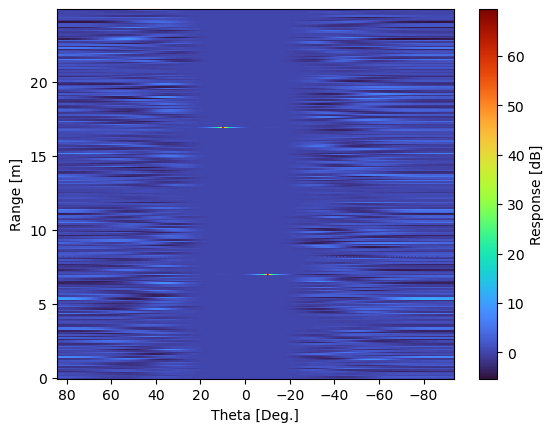

In [ ]:
rmm_dB = 20 * np.log10(np.abs(rmm))

fig, ax = plt.subplots()
cm = ax.pcolor(angle_bins_degrees, range_bin, rmm_dB, cmap='turbo')
fig.colorbar(cm, ax=ax, label='Response [dB]')
ax.invert_xaxis()
ax.set_xlabel('Theta [Deg.]')
ax.set_ylabel('Range [m]')

Text(0, 0.5, 'Range [m]')

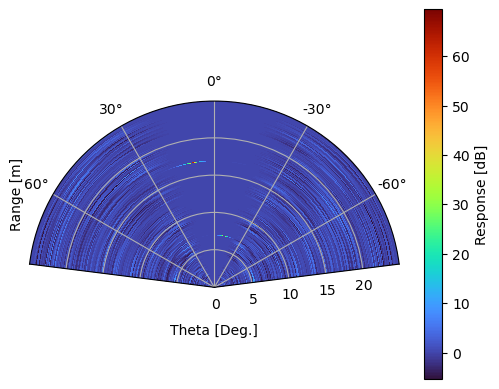

In [ ]:
lim_angle = np.max(angle_bins)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
cm = ax.pcolor(angle_bins, range_bin, rmm_dB, cmap='turbo')
fig.colorbar(cm, ax=ax, label='Response [dB]')
ax.set_theta_zero_location('N')
ax.set_thetalim([-lim_angle, lim_angle])
ax.set_xlabel('Theta [Deg.]', labelpad=-40)
ax.set_ylabel('Range [m]')